# All Import 

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import pandas_profiling as ppf
from scipy.stats import norm,skew
from sklearn.preprocessing import LabelEncoder

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb

# Data Exploration

In [64]:
train=pd.read_csv('/Users/helenswate/Desktop/DM/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/Users/helenswate/Desktop/DM/house-prices-advanced-regression-techniques/test.csv')

In [65]:
#ppf.ProfileReport(train) #hard to view

__1. Analyze SalePrice(Target Variable)__  

In [66]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

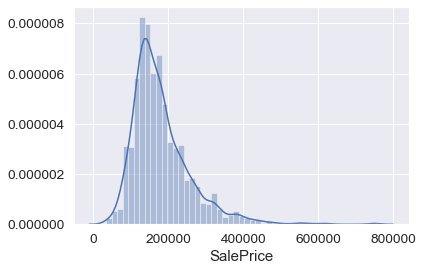

In [67]:
sns.distplot(train["SalePrice"])

In [68]:
price_skew = train["SalePrice"].skew()
price_kurt = train["SalePrice"].kurt()

print("SalePrice Skewness: %f"%price_skew) #skew>0 --> most value < mean value 
print("SalePrice Kurtness: %f"%price_kurt) #kurt>5 --> not normal distribution

SalePrice Skewness: 1.882876
SalePrice Kurtness: 6.536282


__1) SalePrice Conclustion__  
+ It is not normally distributed
+ rightly skewed

+ It has couple of outliers at the upper end

__2. Correlation Analysis__  

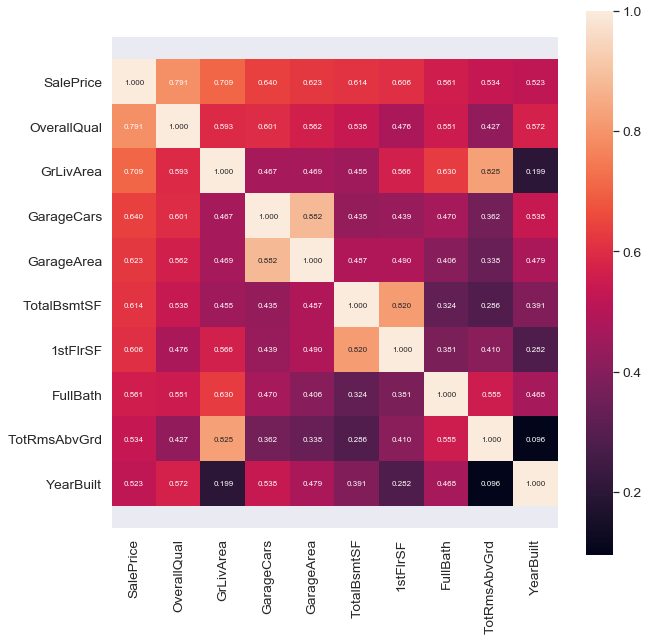

In [69]:
correlation_train = train.corr()
cols = correlation_train.nlargest(10, 'SalePrice')['SalePrice'].index
f , ax = plt.subplots(figsize = (10,10))
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.3f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

The correlation matrix shows, the attribute with lighter color has stronger correlation with SalePrice.
Results: 
+ OverallQual
+ GrLivArea(TotRmsAbvGrd: cuz strong correliert)
+ GarageCars(GarageArea)
+ TotalBsmtSF(1stFlrSF)
+ FullBath
+ YearBuilt

__3. Main Attributes with SalePrice__ 

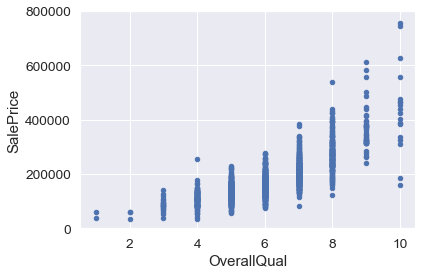

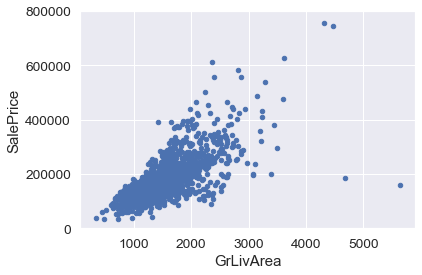

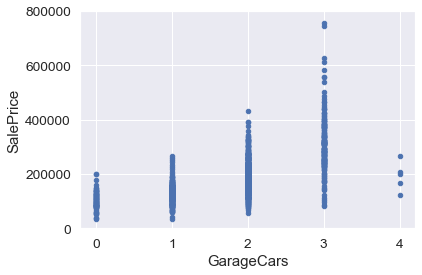

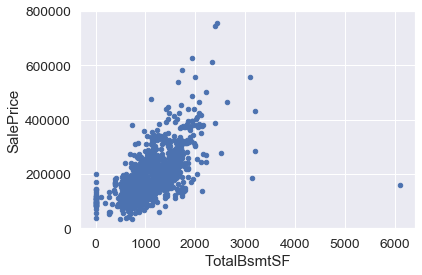

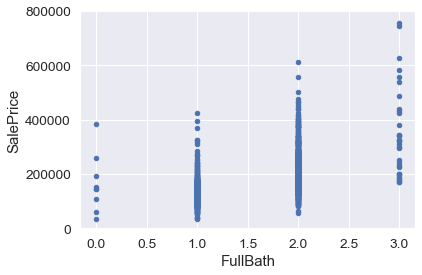

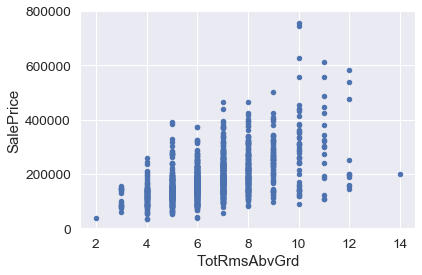

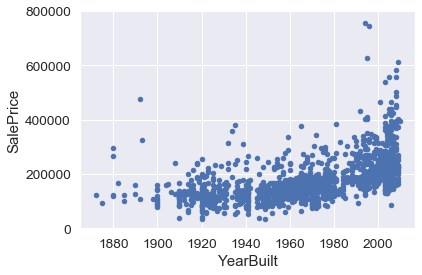

In [70]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
cols = ["OverallQual","GrLivArea", "GarageCars","TotalBsmtSF", "FullBath", "TotRmsAbvGrd", "YearBuilt"]
for item in cols:
    data = pd.concat([train["SalePrice"], train[item]], axis=1)
    data.plot.scatter(x=item, y="SalePrice", ylim=(0,800000));

# Data Cleaning

In [71]:
#1.drop column id
#train.info()
#test.info()
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


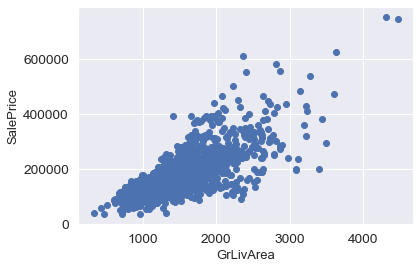

In [72]:
#2.Outlier
#From the scatter diagram for GrLivArea and SalePrice, we found 2 ooutliers that need to be deleted.
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

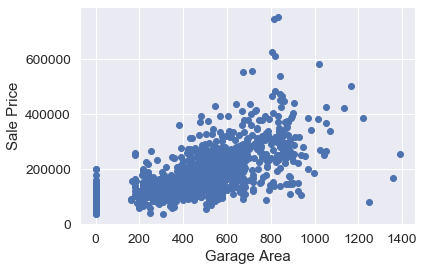

In [73]:
plt.scatter(x=train['GarageArea'], y=train['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()
train = train[train['GarageArea'] < 1200]

__3.SalePrice__
+ From the SalePrice Conclusion above we know that SalePrice is not normally distributed
+ we need to make it normally distributed

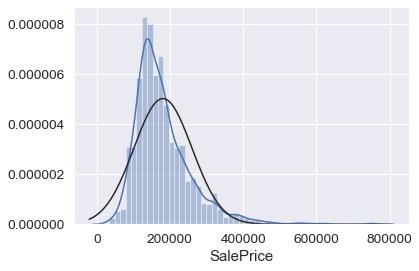

In [74]:
#3.SalePrice is not normally distributed
from scipy.stats import norm,skew
sns.distplot(train['SalePrice'] , fit=norm)
plt.show()

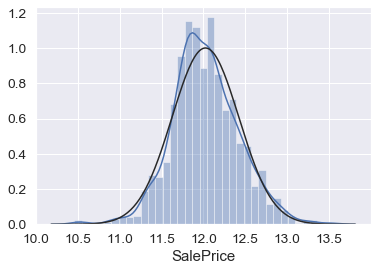

In [75]:
#so we transform it into normal distribution using log function
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice'] , fit=norm)
plt.show()

__4. Missing Data__
+ For training and test

In [76]:
#Missing value
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
# ****************************************************************(all_data,sort=false)
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2913, 79)


In [77]:
total= all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(30)

,Total,Percent
PoolQC,2904,99.691040
MiscFeature,2809,96.429797
Alley,2715,93.202884
Fence,2342,80.398215
FireplaceQu,1419,48.712667
LotFrontage,485,16.649502
GarageFinish,159,5.458290
GarageQual,159,5.458290
GarageYrBlt,159,5.458290
GarageCond,159,5.458290


1) From the table above we know that PoolQC has more than 99% missing value, it means most houses dont have pool, so lets see its value types firstly.It is suitable to fill its missing value with None, same condition in MiscFeature, Alley, Fence, FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond...

In [78]:
train["PoolQC"].value_counts()
count=0
for col in ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"MasVnrType",'MSSubClass'):
    count+=1
    all_data[col] = all_data[col].fillna('None')
print(count)

#Median
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median())) #cuz neighborhood Lotfrontage similiar

#typ
all_data["Functional"] = all_data["Functional"].fillna("Typ")
print('Shape all_data: {}'.format(all_data.shape))

#same
#all_data = all_data.drop(['Utilities'], axis=1) # two Missing valuse, except one "NoSeWa", last "AllPub",thus  varianz small -->delete it
#print('Shape all_data: {}'.format(all_data.shape))

#mode
for col in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0]) 

#0 
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',"MasVnrArea"):
    all_data[col] = all_data[col].fillna(0)

16
Shape all_data: (2913, 79)


In [79]:
print(all_data.isnull().sum().max()) 

2


In [80]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Feature Engineering

1. Although some attributes are numeric, but they are categorical

In [81]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str) 
all_data['YrSold'] = all_data['YrSold'].astype(str)  
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

2. Categorical(Label Encoding)

In [82]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2913, 80)


3. Skewed features

In [83]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.934376
PoolArea,17.676417
LotArea,13.162340
LowQualFinSF,12.076090
3SsnPorch,11.364106
LandSlope,4.991687
KitchenAbvGr,4.297140
BsmtFinSF2,4.141222
EnclosedPorch,3.999248
ScreenPorch,3.941914


In [84]:
from scipy.stats import norm,skew
from scipy.special import boxcox1p
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)  


There are 59 skewed numerical features to Box Cox transform

Skew in numerical features: 



,Skew
PoolArea,15.748589
3SsnPorch,8.915302
LowQualFinSF,8.734802
MiscVal,5.623328
LandSlope,4.546519
BsmtHalfBath,3.783568
KitchenAbvGr,3.694257
ScreenPorch,2.974364
BsmtFinSF2,2.560743
EnclosedPorch,2.022041


In [85]:
all_data = pd.get_dummies(all_data) #one-hot encoding
print(all_data.shape)

(2913, 222)


In [86]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

In [87]:
#function in the website
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [88]:
#K-Nearest Neighbours Regressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid_knn = {
    'n_neighbors': [ 2,4,6,8,10, 12, 14, 16, 18, 20,22]
}

grid_search_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = param_grid_knn, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'), refit="neg_mean_absolute_error", cv=5, n_jobs=-1, verbose=3)

# run the grid search
grid_search_knn.fit(train,y_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_knn.cv_results_)
display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format(grid_search_knn.best_score_, grid_search_knn.best_params_))

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   17.3s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,...,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.038361,0.013552,0.639907,0.029952,2,{'n_neighbors': 2},-0.051250,-0.063846,-0.057032,-0.063333,...,0.004616,6,-0.162926,-0.189259,-0.170597,-0.184410,-0.176620,-0.176763,0.009428,6
1,0.028357,0.005634,0.777396,0.196712,4,{'n_neighbors': 4},-0.050853,-0.062726,-0.052257,-0.056378,...,0.004146,1,-0.161696,-0.180717,-0.163859,-0.167169,-0.174478,-0.169580,0.007054,1
2,0.022408,0.005456,1.085145,0.047635,6,{'n_neighbors': 6},-0.050732,-0.062397,-0.053709,-0.059358,...,0.004116,2,-0.163412,-0.180461,-0.162702,-0.172764,-0.176877,-0.171239,0.007119,2
3,0.028670,0.007956,0.909432,0.121597,8,{'n_neighbors': 8},-0.048335,-0.064319,-0.053405,-0.061142,...,0.005637,3,-0.156852,-0.186017,-0.165660,-0.177587,-0.179622,-0.173143,0.010479,4
4,0.026440,0.006937,0.855940,0.013482,10,{'n_neighbors': 10},-0.048829,-0.065311,-0.051743,-0.062485,...,0.006239,4,-0.156762,-0.188139,-0.161985,-0.180617,-0.177116,-0.172921,0.011744,3
5,0.030369,0.005090,0.859110,0.046624,12,{'n_neighbors': 12},-0.049307,-0.065267,-0.052889,-0.063106,...,0.006009,5,-0.157299,-0.188156,-0.164569,-0.182874,-0.179323,-0.174441,0.011617,5
6,0.038122,0.011847,0.806675,0.094400,14,{'n_neighbors': 14},-0.051101,-0.067355,-0.054678,-0.065892,...,0.006399,7,-0.161009,-0.192433,-0.165838,-0.188562,-0.178249,-0.177218,0.012280,7
7,0.036837,0.019819,0.912220,0.093871,16,{'n_neighbors': 16},-0.051604,-0.068918,-0.056673,-0.066840,...,0.006620,8,-0.163341,-0.196596,-0.167283,-0.189788,-0.177663,-0.178935,0.012734,8
8,0.046904,0.040875,1.211379,0.156019,18,{'n_neighbors': 18},-0.052783,-0.069124,-0.057833,-0.068021,...,0.006321,9,-0.164309,-0.196903,-0.168694,-0.191924,-0.179501,-0.180267,0.012668,9
9,0.066130,0.032973,1.048933,0.306242,20,{'n_neighbors': 20},-0.053657,-0.069914,-0.059715,-0.067472,...,0.005991,10,-0.165394,-0.198823,-0.171029,-0.191227,-0.179099,-0.181116,0.012404,10


best score is -0.1695804814722261 with params {'n_neighbors': 4}


In [89]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_val_score, KFold, RandomizedSearchCV
parameters_rf = {
    'n_estimators': [int(x) for x in np.linspace(start = 600, stop=1800,num=6)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=8)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap':[True, False],
    'warm_start': [True]
}

# create the grid search instance
rand_search_est_rf = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions = parameters_rf, scoring=('mean_squared_error', 'mean_absolute_error'), refit="neg_mean_absolute_error",n_iter=15, cv=4, random_state=42, n_jobs=-1, verbose=5)

# run the grid search
rand_search_est_rf.fit(train, y_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(rand_search_est_rf.cv_results_)
display(results)
    
# print the best parameter setting
print("best score is {} with params {}".format((rand_search_est_rf.best_score_), rand_search_est_rf.best_params_))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.2min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_warm_start,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,79.744490,1.728627,0.793579,0.365112,True,1560,5,4,auto,38,...,-0.035805,0.005526,15,-0.134314,-0.149912,-0.133936,-0.128821,-0.136753,0.007907,14
1,15.446547,0.117519,0.562494,0.032099,True,840,2,1,sqrt,81,...,-0.018078,0.003515,1,-0.086983,-0.098554,-0.084137,-0.089215,-0.089727,0.005409,1
2,5.894558,0.728027,0.515703,0.154173,True,1080,10,4,sqrt,110,...,-0.022124,0.004362,10,-0.094415,-0.108108,-0.092851,-0.096555,-0.097987,0.005995,10
3,11.183709,0.148560,0.684398,0.107725,True,1560,10,4,sqrt,52,...,-0.020543,0.004182,8,-0.090952,-0.104669,-0.089129,-0.093288,-0.094514,0.006050,4
4,48.601440,0.658504,0.382210,0.026550,True,1080,10,4,auto,38,...,-0.035083,0.005391,12,-0.134530,-0.149476,-0.129956,-0.129605,-0.135900,0.008082,12
5,62.977157,1.098701,0.439880,0.016896,True,1320,10,1,auto,38,...,-0.033534,0.003337,11,-0.130309,-0.142664,-0.123876,-0.132148,-0.132255,0.006753,11
6,4.714794,0.172898,0.427229,0.043094,True,1080,10,4,sqrt,110,...,-0.020518,0.004114,7,-0.090785,-0.104458,-0.089706,-0.093151,-0.094529,0.005871,5
7,3.590666,0.046292,0.262850,0.033598,True,600,2,2,sqrt,24,...,-0.018936,0.003729,3,-0.087681,-0.100424,-0.086044,-0.090094,-0.091065,0.005597,3
8,29.018339,0.543800,0.231555,0.013064,True,600,2,2,auto,110,...,-0.035132,0.004747,14,-0.136262,-0.150947,-0.126211,-0.135501,-0.137239,0.008854,15
9,21.522489,0.235041,0.272977,0.005402,True,840,10,1,auto,24,...,-0.019673,0.002667,6,-0.097159,-0.101400,-0.090872,-0.097211,-0.096664,0.003759,8


best score is -0.08972650305703776 with params {'warm_start': True, 'n_estimators': 840, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 81, 'bootstrap': False}


1. Lasso

In [90]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

NameError: name 'xgb' is not defined

In [ ]:
score = rmsle_cv(lasso)  
print("nLasso score: {:.4f} ({:.4f})n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15